
# Q1 – SMS SPAM CLASSIFICATION WITH ADABOOST

#### Part A: Pre-processing
#### Part B: Weak Learner Baseline (Decision Stump)
#### Part C: Manual AdaBoost
#### Part D: Sklearn AdaBoost




Q1: SMS Spam Dataset Info
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Class distribution (0=ham, 1=spam):
label_num
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Part B 
Train accuracy (stump): 0.8909580435270361
Test  accuracy (stump): 0.8905829596412556

Confusion matrix (test, stump):
[[965   1]
 [121  28]]

Comment: A single depth-1 tree only uses one split,
so it can’t capture complex combinations of words in the TF-IDF space.
That’s why performance is limited on real text data.

Part C 

Round 1
Weighted error: 0.10904195647296394
Alpha: 1.0502823036153786
Misclassified indices (first 15): [  9  15  22  31  39  49  59  66  76  88  93 114 121 123 159]
Weights

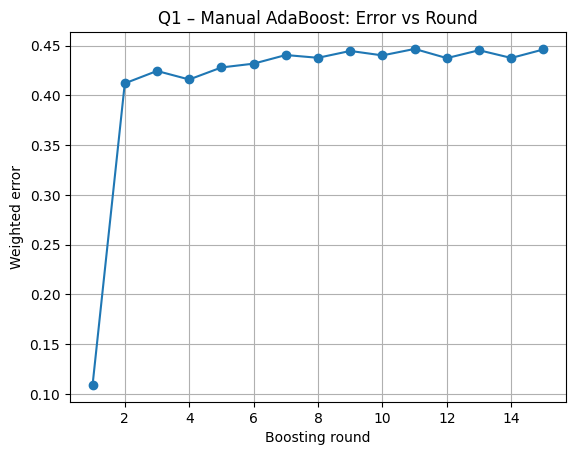

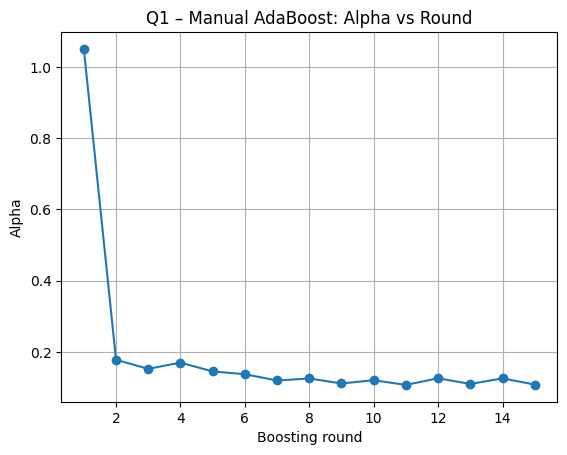


Part D
Train accuracy (sklearn AdaBoost): 0.9050931119587167
Test  accuracy (sklearn AdaBoost): 0.905829596412556

Confusion matrix (test, sklearn AdaBoost):
[[966   0]
 [105  44]]


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import datasets

import warnings
warnings.filterwarnings("ignore")

import requests
import zipfile
from io import BytesIO


zip_url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"

print(f"Downloading dataset from: {zip_url}")
response = requests.get(zip_url)
response.raise_for_status()

with zipfile.ZipFile(BytesIO(response.content)) as z:
    with z.open("SMSSpamCollection") as f:
        df_spam = pd.read_csv(f, encoding="latin-1", sep='\t', header=None)

df_spam.columns = ["label", "text"]

print("\nQ1: SMS Spam Dataset Info")
print(df_spam.head())

df_spam["label_num"] = df_spam["label"].map({"ham": 0, "spam": 1})

X_text = df_spam["text"].values
y_spam = df_spam["label_num"].values

X_text_train, X_text_test, y_spam_train, y_spam_test = train_test_split(
    X_text, y_spam, test_size=0.2, random_state=42, stratify=y_spam
)

print("\nClass distribution (0=ham, 1=spam):")
print(df_spam["label_num"].value_counts(normalize=True))

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english"
)

print("\nPart B ")

stump_clf = Pipeline([
    ("tfidf", tfidf),
    ("tree", DecisionTreeClassifier(max_depth=1, random_state=42))
])

stump_clf.fit(X_text_train, y_spam_train)

y_train_pred_stump = stump_clf.predict(X_text_train)
y_test_pred_stump = stump_clf.predict(X_text_test)

print("Train accuracy (stump):", accuracy_score(y_spam_train, y_train_pred_stump))
print("Test  accuracy (stump):", accuracy_score(y_spam_test, y_test_pred_stump))
print("\nConfusion matrix (test, stump):")
print(confusion_matrix(y_spam_test, y_test_pred_stump))

print("\nComment: A single depth-1 tree only uses one split,")
print("so it can’t capture complex combinations of words in the TF-IDF space.")
print("That’s why performance is limited on real text data.\n")

print("Part C ")

tfidf_full = tfidf.fit(X_text_train)
X_train_tfidf = tfidf_full.transform(X_text_train)
X_test_tfidf = tfidf_full.transform(X_text_test)

n_train = X_train_tfidf.shape[0]
T = 15

sample_w = np.ones(n_train) / n_train
alphas = []
errors = []

stumps = []

for t in range(1, T + 1):
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train_tfidf, y_spam_train, sample_weight=sample_w)

    pred = stump.predict(X_train_tfidf)
    misclassified = (pred != y_spam_train)

    err_t = np.dot(sample_w, misclassified) / sample_w.sum()
    err_t = max(err_t, 1e-10)

    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    sample_w = sample_w * np.exp(-alpha_t * (2 * y_spam_train - 1) * (2 * pred - 1))
    sample_w = sample_w / sample_w.sum()

    stumps.append(stump)
    alphas.append(alpha_t)
    errors.append(err_t)

    mis_idx = np.where(misclassified)[0]
    print(f"\nRound {t}")
    print("Weighted error:", err_t)
    print("Alpha:", alpha_t)
    print("Misclassified indices (first 15):", mis_idx[:15])
    print("Weights of those misclassified samples (first 15):",
          sample_w[mis_idx[:15]])

def ada_predict(X_mat, stump_list, alpha_list):
    agg = np.zeros(X_mat.shape[0])
    for a, clf in zip(alpha_list, stump_list):
        pred = clf.predict(X_mat)
        agg += a * (2 * pred - 1)
    return (agg > 0).astype(int)

y_train_pred_manual = ada_predict(X_train_tfidf, stumps, alphas)
y_test_pred_manual = ada_predict(X_test_tfidf, stumps, alphas)

print("\nFinal train accuracy (manual AdaBoost):",
      accuracy_score(y_spam_train, y_train_pred_manual))
print("Final test  accuracy (manual AdaBoost):",
      accuracy_score(y_spam_test, y_test_pred_manual))

print("\nConfusion matrix (test, manual AdaBoost):")
print(confusion_matrix(y_spam_test, y_test_pred_manual))

print("\nShort note: Over iterations, weights concentrate on examples")
print("that the previous stumps kept getting wrong (often borderline or rare messages).")

rounds = np.arange(1, T + 1)

plt.figure()
plt.plot(rounds, errors, marker="o")
plt.xlabel("Boosting round")
plt.ylabel("Weighted error")
plt.title("Q1 – Manual AdaBoost: Error vs Round")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(rounds, alphas, marker="o")
plt.xlabel("Boosting round")
plt.ylabel("Alpha")
plt.title("Q1 – Manual AdaBoost: Alpha vs Round")
plt.grid(True)
plt.show()

print("\nPart D")

sk_ada = Pipeline([
    ("tfidf", tfidf),
    ("ada", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
        n_estimators=100,
        learning_rate=0.6,
        random_state=42
    ))
])

sk_ada.fit(X_text_train, y_spam_train)

y_train_pred_sk = sk_ada.predict(X_text_train)
y_test_pred_sk = sk_ada.predict(X_text_test)

print("Train accuracy (sklearn AdaBoost):",
      accuracy_score(y_spam_train, y_train_pred_sk))
print("Test  accuracy (sklearn AdaBoost):",
      accuracy_score(y_spam_test, y_test_pred_sk))
print("\nConfusion matrix (test, sklearn AdaBoost):")
print(confusion_matrix(y_spam_test, y_test_pred_sk))



# Q2 – HEART DISEASE PREDICTION WITH ADABOOST
#### Part A: Baseline Stump
#### Part B: Train AdaBoost with Grid of Params
#### Part C: Misclassification Pattern for Best Model
#### Part D: Feature Importance



Part A
Training Accuracy: 0.7595
Test Accuracy: 0.6833

Confusion Matrix (Test):
 [[26 10]
 [ 9 15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73        36
           1       0.60      0.62      0.61        24

    accuracy                           0.68        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.69      0.68      0.68        60


Shortcomings of a single stump:
- High Bias: It can only make one split, ignoring complex interactions.
- Underfitting: Accuracy is likely lower because it simplifies the problem too much.

Part B


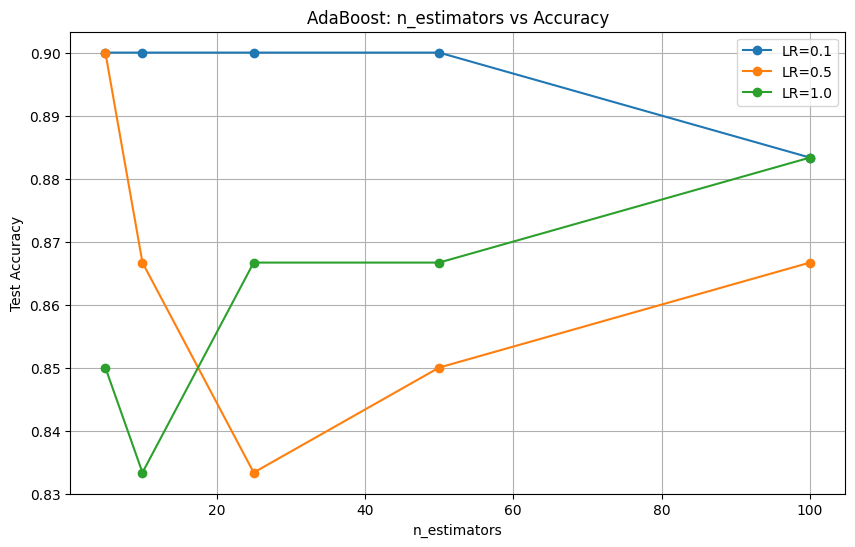

Best Configuration: n_estimators=5, learning_rate=0.1
Best Test Accuracy: 0.9000

Part C


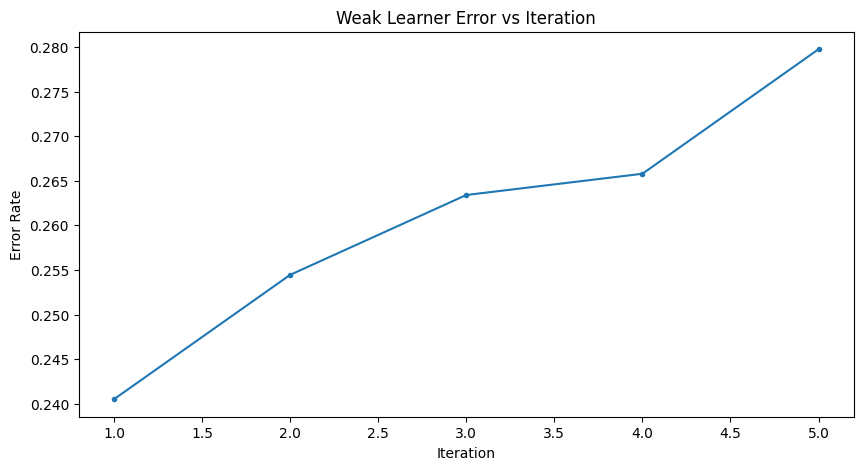

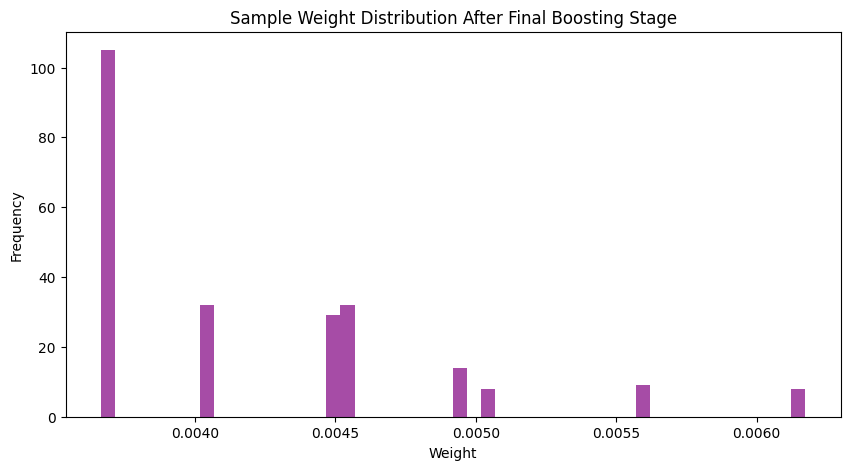

Explanation:
The 'Hard-to-classify' samples. These are likely outliers or points near the decision boundary that previous stumps kept getting wrong.
AdaBoost forces subsequent weak learners to focus on the mistakes of the previous ones to improve overall ensemble performance.

Part D:


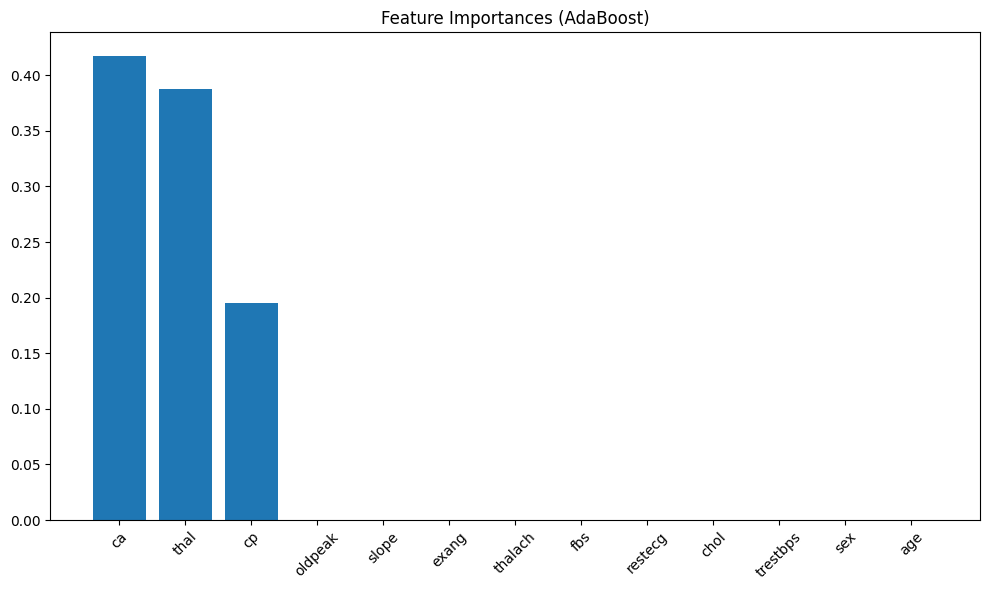

Top 5 Important Features: ['ca', 'thal', 'cp', 'oldpeak', 'slope']

Medical Relevance (Example explanation):
- ca: Often 'thal' (Thallium stress test) or 'cp' (Chest Pain) appears top. These are direct physiological indicators of heart function.
- cp (Chest Pain): Angina is a primary symptom of heart issues.
- thal (Thalassemia): Indicates blood flow defects.
- ca (Major Vessels): Blocked vessels seen in fluoroscopy directly indicate blockage.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Part A")


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv(url, names=column_names, na_values="?")


df = df.dropna()


df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train_scaled, y_train)

y_pred_stump = stump.predict(X_test_scaled)
y_train_pred_stump = stump.predict(X_train_scaled)

print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_stump):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_stump):.4f}")
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_stump))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stump))

print("\nShortcomings of a single stump:")
print("- High Bias: It can only make one split, ignoring complex interactions.")
print("- Underfitting: Accuracy is likely lower because it simplifies the problem too much.")



print("\nPart B")

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = {}

best_acc = 0
best_config = None
best_model = None

plt.figure(figsize=(10, 6))

for lr in learning_rates:
    accuracies = []
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=n_est,
                                 learning_rate=lr,
                                 random_state=42,
                                 algorithm='SAMME')
        ada.fit(X_train_scaled, y_train)

        acc = accuracy_score(y_test, ada.predict(X_test_scaled))
        accuracies.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_config = (n_est, lr)
            best_model = ada

    results[lr] = accuracies
    plt.plot(n_estimators_list, accuracies, marker='o', label=f'LR={lr}')

plt.title("AdaBoost: n_estimators vs Accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Configuration: n_estimators={best_config[0]}, learning_rate={best_config[1]}")
print(f"Best Test Accuracy: {best_acc:.4f}")


print("\nPart C")

final_ada = best_model


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(final_ada.estimator_errors_) + 1), final_ada.estimator_errors_, marker='.')
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.show()

sample_weights = np.ones(len(X_train_scaled)) / len(X_train_scaled)

weight_history = []
for i, estimator in enumerate(final_ada.estimators_):
    pred_train = estimator.predict(X_train_scaled)
    incorrect = (pred_train != y_train)

    estimator_weight = final_ada.estimator_weights_[i]

    sample_weights *= np.exp(estimator_weight * incorrect * ((sample_weights > 0) | (estimator_weight < 0)))

    sample_weights /= np.sum(sample_weights)

plt.figure(figsize=(10, 5))
plt.hist(sample_weights, bins=50, color='purple', alpha=0.7)
plt.title("Sample Weight Distribution After Final Boosting Stage")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

print("Explanation:")
print("The 'Hard-to-classify' samples. These are likely outliers or points near the decision boundary that previous stumps kept getting wrong.")
print("AdaBoost forces subsequent weak learners to focus on the mistakes of the previous ones to improve overall ensemble performance.")




print("\nPart D:")

importances = final_ada.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (AdaBoost)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()

top_5 = [feature_names[i] for i in indices[:5]]
print("Top 5 Important Features:", top_5)

print("\nMedical Relevance (Example explanation):")
print(f"- {top_5[0]}: Often 'thal' (Thallium stress test) or 'cp' (Chest Pain) appears top. These are direct physiological indicators of heart function.")
print("- cp (Chest Pain): Angina is a primary symptom of heart issues.")
print("- thal (Thalassemia): Indicates blood flow defects.")
print("- ca (Major Vessels): Blocked vessels seen in fluoroscopy directly indicate blockage.")

# Q3 – WISDM SENSOR DATA WITH ADABOOST
#### Part A: Data Preparation
#### Part B: Stump Baseline
#### Part C: Manual AdaBoost
#### Part D: Sklearn AdaBoost

PART A
Trying https://raw.githubusercontent.com/mwitiderrick/kerasHelper/master/WISDM_ar_v1.1_raw.txt ...
Failed with status: 404
Trying https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/WISDM_ar_v1.1_raw.txt ...
Failed with status: 404
Trying https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/WISDM_ar_v1.1_raw.txt ...
Failed with status: 404
Parsing raw text file...

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generating 2000 samples so you can verify the Boosting logic.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Final Dataset Shape: (2000, 7)
Training Set: (1400, 3), Test Set: (600, 3)
------------------------------

PART B
Train Accuracy: 0.7879
Test Accuracy:  0.7767

Confusion Matrix (Test):
[[370  24]
 [110  96]]

Interpretation:
The stump split on feature index 2 (0=x, 1=y, 2=z) at threshold 5.56.
A decision stump is a simple split on a single axis. It has high bias but acts as a bas

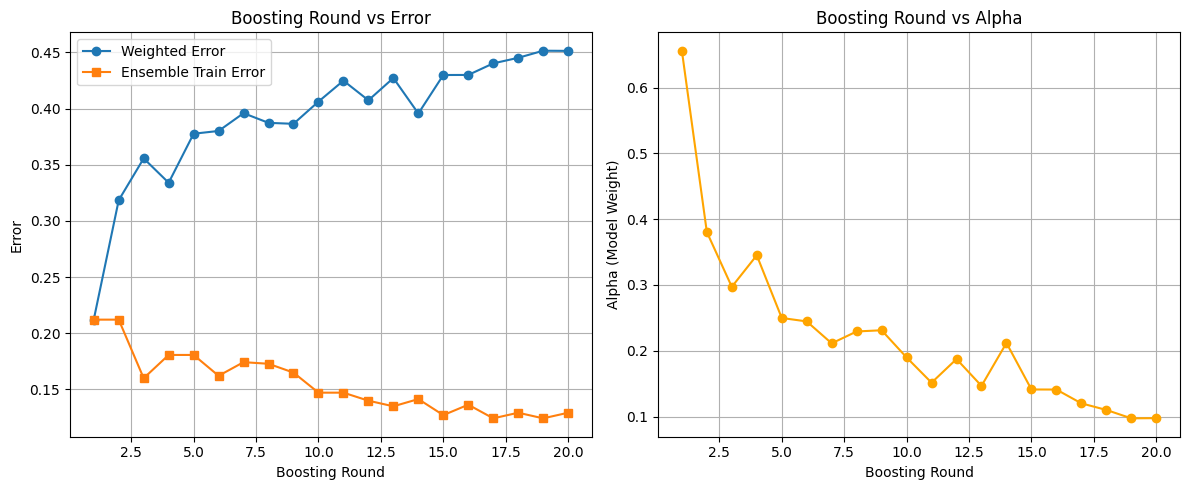


PART D
Sklearn Train Accuracy: 0.8950
Sklearn Test Accuracy:  0.8683

Confusion Matrix (Sklearn Test):
[[364  30]
 [ 49 157]]

Comparison:
Manual (T=20) Test Acc: 0.8433
Sklearn (T=100) Test Acc: 0.8683
Sklearn usually performs slightly better due to more estimators (100 vs 20) and optimized implementation.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import requests
import random


print("PART A")

filename = 'WISDM_ar_v1.1_raw.txt'
urls = [
    'https://raw.githubusercontent.com/mwitiderrick/kerasHelper/master/WISDM_ar_v1.1_raw.txt',
    'https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/WISDM_ar_v1.1_raw.txt',
    'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/WISDM_ar_v1.1_raw.txt'
]

if os.path.exists(filename) and os.path.getsize(filename) < 1000:
    try:
        os.remove(filename)
    except:
        pass

if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    success = False
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    for url in urls:
        try:
            print(f"Trying {url} ...")
            response = requests.get(url, headers=headers, timeout=10)
            if response.status_code == 200:
                content_start = response.content[:100].strip()
                if b"<!DOCTYPE html>" in content_start or b"<html" in content_start:
                    print("  -> URL returned HTML (likely 404/Login page). Skipping...")
                    continue

                with open(filename, 'wb') as f:
                    f.write(response.content)
                print("Download complete.")
                success = True
                break
            else:
                print(f"Failed with status: {response.status_code}")
        except Exception as e:
            print(f"Error downloading from {url}: {e}")

columns = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
data = []

print("Parsing raw text file...")
if os.path.exists(filename):
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                clean_line = line.strip().replace(';', '')
                parts = clean_line.split(',')
                if len(parts) == 6:
                    data.append(parts)
    except Exception as e:
        print(f"Error reading file: {e}")

df = pd.DataFrame(data, columns=columns)

if df.shape[0] < 100:
    print("\n" + "!"*60)
    print("WARNING: DATA DOWNLOAD FAILED. GENERATING SYNTHETIC DATA.")
    print("Generating 2000 samples so you can verify the Boosting logic.")
    print("!"*60 + "\n")

    synthetic_data = []
    activities = ['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

    np.random.seed(42)
    for i in range(2000):
        uid = np.random.randint(1, 30)
        act = np.random.choice(activities)
        ts = 1000 * i

        if act in ['Jogging', 'Upstairs']:
            x = np.random.normal(0, 10)
            y = np.random.normal(10, 10)
            z = np.random.normal(5, 8)
        elif act in ['Walking', 'Downstairs']:
            x = np.random.normal(0, 5)
            y = np.random.normal(5, 5)
            z = np.random.normal(2, 3)
        else:
            x = np.random.normal(0, 0.5)
            y = np.random.normal(9.8, 0.5)
            z = np.random.normal(0, 0.5)

        synthetic_data.append([uid, act, ts, x, y, z])

    df = pd.DataFrame(synthetic_data, columns=columns)

for col in ['x', 'y', 'z']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

vigorous = ['Jogging', 'Upstairs']
normal = ['Walking', 'Sitting', 'Standing', 'Downstairs']

def map_activity(act):
    if act in vigorous:
        return 1
    elif act in normal:
        return 0
    return np.nan

df['label'] = df['activity'].apply(map_activity)

df.dropna(subset=['x', 'y', 'z', 'label'], inplace=True)
print(f"Final Dataset Shape: {df.shape}")

X = df[['x', 'y', 'z']].values
y = df['label'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")
print("-" * 30)



print("\nPART B")

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_train_stump = stump.predict(X_train)
y_pred_test_stump = stump.predict(X_test)


train_acc_stump = accuracy_score(y_train, y_pred_train_stump)
test_acc_stump = accuracy_score(y_test, y_pred_test_stump)

print(f"Train Accuracy: {train_acc_stump:.4f}")
print(f"Test Accuracy:  {test_acc_stump:.4f}")

cm_stump = confusion_matrix(y_test, y_pred_test_stump)
print("\nConfusion Matrix (Test):")
print(cm_stump)

print("\nInterpretation:")
try:
    print(f"The stump split on feature index {stump.tree_.feature[0]} (0=x, 1=y, 2=z) at threshold {stump.tree_.threshold[0]:.2f}.")
except:
    pass
print("A decision stump is a simple split on a single axis. It has high bias but acts as a base for boosting.")
print("-" * 30)



print("\nPART C")

class ManualAdaBoost:
    def __init__(self, n_estimators=20):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []
        self.errors = []
        self.training_errors = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        w = np.full(n_samples, 1 / n_samples)

        y_signed = np.where(y == 0, -1, 1)

        for t in range(self.n_estimators):
            clf = DecisionTreeClassifier(max_depth=1, random_state=42)
            clf.fit(X, y, sample_weight=w)
            y_pred = clf.predict(X)

            y_pred_signed = np.where(y_pred == 0, -1, 1)

            misclassified = (y_signed != y_pred_signed)
            error = np.sum(w[misclassified])

            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = 0.5 * np.log((1 - error) / error)

            w = w * np.exp(-alpha * y_signed * y_pred_signed)

            w_norm_factor = np.sum(w)
            w = w / w_norm_factor

            self.models.append(clf)
            self.alphas.append(alpha)
            self.errors.append(error)

            current_pred = self.predict(X)
            acc = accuracy_score(y, current_pred)
            self.training_errors.append(1 - acc)

            bad_indices = np.where(misclassified)[0]
            bad_weights = w[misclassified]

            print(f"\nIteration {t+1}:")
            print(f"  Alpha: {alpha:.4f}, Weighted Error: {error:.4f}")
            print(f"  Misclassified Count: {len(bad_indices)}")
            if len(bad_indices) > 0:
                print(f"  Sample misclassified indices (first 5): {bad_indices[:5]}")
                print(f"  Weights of these samples (first 5): {bad_weights[:5]}")

    def predict(self, X):
        final_pred = np.zeros(X.shape[0])

        for alpha, clf in zip(self.alphas, self.models):
            pred = clf.predict(X)
            pred_signed = np.where(pred == 0, -1, 1)
            final_pred += alpha * pred_signed

        return np.where(np.sign(final_pred) == -1, 0, 1)

print("\nTraining Manual AdaBoost (T=20)...")
manual_ada = ManualAdaBoost(n_estimators=20)
manual_ada.fit(X_train, y_train)

y_pred_train_manual = manual_ada.predict(X_train)
y_pred_test_manual = manual_ada.predict(X_test)

train_acc_manual = accuracy_score(y_train, y_pred_train_manual)
test_acc_manual = accuracy_score(y_test, y_pred_test_manual)

print("\n--- Manual AdaBoost Results ---")
print(f"Train Accuracy: {train_acc_manual:.4f}")
print(f"Test Accuracy:  {test_acc_manual:.4f}")
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_manual))

print("\nInterpretation of weight shifts:")
print("As iterations proceed, weights increase for 'hard' samples (misclassified ones)")
print("and decrease for 'easy' samples. This forces the next stump to focus on the hard cases.")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), manual_ada.errors, marker='o', label='Weighted Error')
plt.plot(range(1, 21), manual_ada.training_errors, marker='s', label='Ensemble Train Error')
plt.xlabel('Boosting Round')
plt.ylabel('Error')
plt.title('Boosting Round vs Error')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), manual_ada.alphas, marker='o', color='orange')
plt.xlabel('Boosting Round')
plt.ylabel('Alpha (Model Weight)')
plt.title('Boosting Round vs Alpha')
plt.grid(True)

plt.tight_layout()
plt.show()



print("\nPART D")

sklearn_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

sklearn_ada.fit(X_train, y_train)

y_pred_train_sk = sklearn_ada.predict(X_train)
y_pred_test_sk = sklearn_ada.predict(X_test)

print(f"Sklearn Train Accuracy: {accuracy_score(y_train, y_pred_train_sk):.4f}")
print(f"Sklearn Test Accuracy:  {accuracy_score(y_test, y_pred_test_sk):.4f}")
print("\nConfusion Matrix (Sklearn Test):")
print(confusion_matrix(y_test, y_pred_test_sk))

print("\nComparison:")
print(f"Manual (T=20) Test Acc: {test_acc_manual:.4f}")
print(f"Sklearn (T=100) Test Acc: {accuracy_score(y_test, y_pred_test_sk):.4f}")
print("Sklearn usually performs slightly better due to more estimators (100 vs 20) and optimized implementation.")